# Simple acoustic wave 2D

In this tutorial, we demonstrate how to simulate acoustic wave propagation in 2D domain using pywave.

First, we define the number of points and the grid spacing (in meters) in each dimension.

In [1]:
from pywave import *
import numpy as np

# number of grid points (z,x)
shape = (512, 512)

# spacing (in meters)
spacing = (15.0, 15.0)

# propagation time (miliseconds)
time = 2000

Next, the velocity model is created. In this example we create a velocity model with two velocity values and stores the data in a numpy array. 

In [2]:
# Velocity model
vel = np.zeros(shape, dtype=np.float32)
vel[:] = 1500.0
vel[256:] = 2500.0
velModel = Model(ndarray=vel)

A second method can read a model from an existing file using the SEGY format in 2D (3D to be implemented):

`velModel = Model(file="path/to/segy_file")`

The velocity model can be ploted as follows.

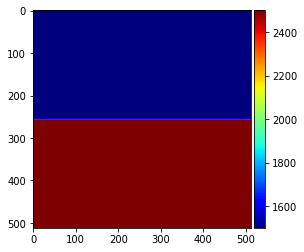

Velocity mode saved in plots/velocity_model.png


In [3]:
plot_velocity_model(velModel)

Now some compiler options are set.

In [4]:
# Compiler
compiler = Compiler(program_version='sequential')

The domain can be extended with an absorbing layer and the halo of the space order. At this point some parameters can be defined:

    nbl : int, optional
        Number of boundary layers (grid points) along sides of the grid (except top).
        Default is 0 points.
    space_order : int, optional
        Finite differences spatial order.
        Default is order 2.
    degree : int, optional
        Degree of the polynomial in the extension function.
        Default is 1 (linear)
    alpha : float, optional
        Constant parameter of the extension function.
        Default is 0.0001

Implementation notes:

Currently, pywave implements only 2nd spatial order.

Absorbing layer is implemented with damping. The damping factor ($\eta$) is zero inside the original domain, while in the extended region it grows linearly:

$\eta(z,x) = \alpha d(z,x)^e$, 

where:

**d** is the perpendicular distance from the point $(z, x)$ to the boundary between original and extended domain;

**e** is a polynomial degree (we used cubic in this example).

More details in: **Y. Gao et al. Comparison of artificial absorbing boundaries for acoustic wave equation modelling, Exploration Geophysics (2017) 76–93.** 

In [5]:
# domain extension (damping + spatial order halo)
extension = DomainExtension(nbl=50, degree=3, alpha=0.0001)

Next, define the source wavelet. Parameters include frequency and amplitude. So far, pywave implements only the Ricker source. 

In [6]:
# Wavelet
wavelet = Wavelet(frequency=5.0)

The class `Source` encapsulates a set of sources that behave according to the `wavelet`. An arbitraty number of sources can be added by the `_.add(position=(z,x))` method wich receives the position in grid points. 
Interpolation is made as described in **Hicks, Graham J. "Arbitrary source and receiver positioning in finite-difference schemes using Kaiser windowed sinc functions." Geophysics 67.1 (2002): 156-165.**
The parameter `kws_half_width` defines the radius of the Kaiser window for the source interpolation. 

In [7]:
# Source
source = Source(kws_half_width=1, wavelet=wavelet)
source.add(position=(30,255.5))

Receivers are defined in a similar way:

In [8]:
# receivers
receivers = Receiver(kws_half_width=1)

for i in range(512):
    receivers.add(position=(15.5,i))

Next, set some configuration parameters for the solver, including:

    velocity_model : object
        Velocity model object.
    sources : object
        Object that represents the set of sources.
    receivers : object
        Object that represents the set of receivers.
    domain_extension : object
        Object that holds the domain extension configuration.
    spacing : tuple(int,...)
        Spacing along each axis.
    progatation_time : int
        Propagation time in miliseconds.
    space_order : int, optional
        Define spatial order. Defaut is 2.
    jumps : int, optional
        Skipping factor when saving the wavefields. Default is 1.
    compiler : object, optional
        Object that represents the compiler.
    density: object, optional
        Density model object.

In [9]:
setup = Setup(
    velocity_model=velModel,
    sources=source,
    receivers=receivers,
    domain_extension=extension,
    spacing=spacing,
    propagation_time=time,
    jumps=1,
    compiler=compiler
)

solver = AcousticSolver(setup=setup)

wavefield, rec, exec_time = solver.forward()

Compilation command: gcc /Users/hermes/Downloads/git/pywave/pywave/kernel/c_code/fixed_spatial_order/forward_sequential.c -O3 -fPIC -Wall -std=c99 -shared -o /Users/hermes/Downloads/git/pywave/tutorial/tmp/lib_c_wave_sequential.so
Model: Acoustic
Dimension: 2D
Shape: (564, 614)
Spacing: (15.0, 15.0)
Density: constant
Space Order: 2
Propagation time: 2000 miliseconds 
DT: 0.004243 seconds
Frequency: 5.0 Hz
Timesteps: 471
Computing forward...


Forward execution time: 1.063294 seconds


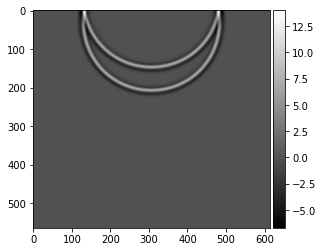

Final wavefield saved in plots/wavefield.png


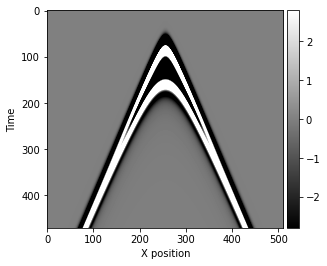

Shotrecord saved in plots/shotrecord.png


In [10]:
print("Forward execution time: %f seconds" % exec_time)

plot_wavefield(wavefield)
plot_shotrecord(rec)